In [2]:
# Practice Problem in analytics Vidya
# https://datahack.analyticsvidhya.com/contest/practice-problem-recommendation-engine/
library('caret')

Loading required package: lattice
Loading required package: ggplot2


In [3]:
train <- read.csv("train.csv")
test <- read.csv("test.csv")

In [4]:
#------------------------------------------------------------------
temp<-setdiff(train$user_id,test$user_id) # 40 New users who are in Train but not in test
length(temp)

[1] 40

In [5]:
temp<-setdiff(test$user_id,train$user_id) # 12 users in test but not in train
length(temp)

[1] 12

In [6]:
temp<-setdiff(train$problem_id,test$problem_id) #1496 new problems which are in train not in test
length(temp)

[1] 1496

In [7]:
temp<-setdiff(test$problem_id,train$problem_id) #436 new problems which are in test not in train
length(temp)

[1] 436

In [8]:
dim(setdiff(train[,1:2],test[,2:3]))
# [1] 155295      2         # 

[1] 155295      2

In [9]:
dim(train)
# [1] 155295      3         # Meaning none of the problem & user combination in train repeated in test
#------------------------------------------------------------------

[1] 155295      3

In [10]:
#Following are the two separate aggregated data sets one group by user and the other by problem 
useragg <- read.csv("useragg.csv")
probagg <- read.csv("problemagg.csv")

In [11]:
names(probagg)=c("problem_id","prob.average.att","Max.prob.attempts","Min.prob.attempts" )
names(useragg)=c("user_id","Min.user.attempts","Max.user.attempts","user.average.att","Count.of.user" )

In [12]:
# -------------------------------------------------------------
#Users data imputation goes here.
users <- read.csv("user_data.csv")
summary(users)

      user_id     submission_count problem_solved    contribution    
 user_1   :   1   Min.   :   1.0   Min.   :   0.0   Min.   :-64.000  
 user_10  :   1   1st Qu.:  66.5   1st Qu.:  53.0   1st Qu.:  0.000  
 user_100 :   1   Median : 169.0   Median : 146.0   Median :  0.000  
 user_1000:   1   Mean   : 299.5   Mean   : 267.9   Mean   :  4.102  
 user_1001:   1   3rd Qu.: 390.0   3rd Qu.: 349.0   3rd Qu.:  0.000  
 user_1002:   1   Max.   :4570.0   Max.   :4476.0   Max.   :171.000  
 (Other)  :3565                                                      
       country     follower_count     last_online_time_seconds   max_rating   
           :1153   Min.   :    0.00   Min.   :1.484e+09        Min.   :303.9  
 India     : 619   1st Qu.:    4.00   1st Qu.:1.503e+09        1st Qu.:317.7  
 Bangladesh: 329   Median :   13.00   Median :1.505e+09        Median :355.8  
 Russia    : 262   Mean   :   46.69   Mean   :1.503e+09        Mean   :390.4  
 China     : 162   3rd Qu.:   40.00   3rd Qu.

In [13]:
for (i in 1:length(users$country)){
    if (users$country[i]==""){
        users$country[i]=NA
  }
}
users$country_num=as.numeric(users$country)

In [14]:
join_users=merge(x=users,y=useragg,by='user_id',all.x=TRUE)
impute_model <- preProcess(join_users, method = c("knnImpute"))
library('RANN')
join_users_impute<-predict(impute_model,join_users)

In [15]:
# -------------------------------------------------------------
# Problem Data imputation 
problem <- read.csv("problem_data.csv")
join_problem=merge(x=problem,y=probagg,by='problem_id',all.x=TRUE)

In [16]:
#Replace spaces with NA
for(i in 1:length(join_problem$level_type)){
  if (join_problem$level_type[i]==""){
    join_problem$level_type[i]=NA
  }
}
join_problem$level_type_num=as.numeric(join_problem$level_type)

In [17]:
for(i in 1:length(join_problem$tags)){
  if (join_problem$tags[i]==""){
    join_problem$tags[i]=NA
  }
}

join_problem$tags_num=as.numeric(join_problem$tags)

In [18]:
join_problem_complete=join_problem[complete.cases(join_problem),]
#join_problem_notcomplete=join_problem[!complete.cases(join_problem),]

impute_model1 <- preProcess(join_problem_complete, method = c("medianImpute"))
library('RANN')
join_problem_impute<-predict(impute_model1,join_problem)
#-----------------------------------------------------------------------

In [19]:
#-----------------------------------------------------------------------
#Joining features with the train set and test set
#https://stackoverflow.com/questions/1299871/how-to-join-merge-data-frames-inner-outer-left-right

#Blend with the user data set that and the problem dataset.
my_test_blend=merge(x=test,y=join_users_impute,by='user_id',all.x=TRUE)
my_train_blend=merge(x=train,y=join_users_impute,by='user_id',all.x=TRUE)

my_test_blend=merge(x=my_test_blend,y=join_problem_impute,by='problem_id',all.x=TRUE)
my_train_blend=merge(x=my_train_blend,y=join_problem_impute,by='problem_id',all.x=TRUE)

testSet  <- my_test_blend
trainSet <- my_train_blend
rm(my_test_blend,my_train_blend)

In [23]:
#modeling part
predictors <-names(trainSet[,c(-1,-2,-3,-7,-19,-21,-27)])
outcomeName <-names(trainSet)[27]
trainSet$target=as.factor(trainSet$attempts_range)

In [24]:
#KNN 
fitControl <- trainControl(
  method = "repeatedcv", # Repeated Cross validation   
  number = 3,            # Three fold cross validation
  repeats = 1)           # Repeat five times

train_data=trainSet[,c(predictors,outcomeName)]

In [ ]:
#Random Forest
model_rforest<-train(target~.,data=train_data,
                 trControl=fitControl,method='cforest')

In [66]:
model_knn<-train(target~.,data=train_data,
                 trControl=fitControl,method='knn')

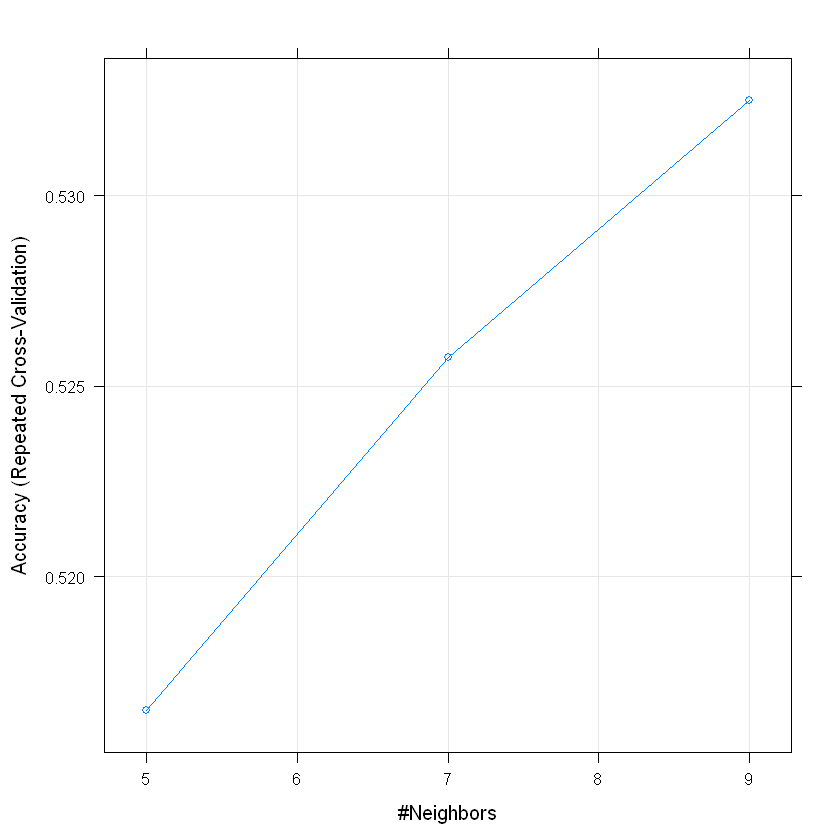

In [69]:
plot(model_knn)

In [67]:
testSet$predicted=predict(model_knn,testSet[,predictors])
temp=merge(test,testSet,by=c('user_id','problem_id'),all.x=TRUE)
upload<-testSet[,c("ID","predicted")]
names(upload)<-c("ID","attempts_range")
library("xlsx")
write.xlsx2(upload, file="upload.xlsx", sheetName="sheet1", row.names=F)